In [1]:
import os
import numpy as np
import toml
import pandas
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn
seaborn.set(style="white")

matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.bottom'] = False
matplotlib.rcParams['axes.spines.left'] = False
font = {'family' : 'Arial',
        'size'   : 18}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('figure', figsize=(11, 6.8))
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('legend', fontsize=18)
matplotlib.rc('axes', labelsize=18)

In [2]:
RESULT_DIR = '../results/'
def read_experiment(name):
    flags_path = os.path.join(RESULT_DIR, name, "options.toml")
    log_path = os.path.join(RESULT_DIR, name, "log.csv")
    try:
        log = pandas.read_csv(log_path)
    except pandas.errors.EmptyDataError:
        return None
    return {
        'log': log,
        'flags': toml.load(flags_path)
    }

In [3]:
experiments = os.listdir(RESULT_DIR)
experiments = [read_experiment(name) for name in experiments]
experiments = [e for e in experiments if e]

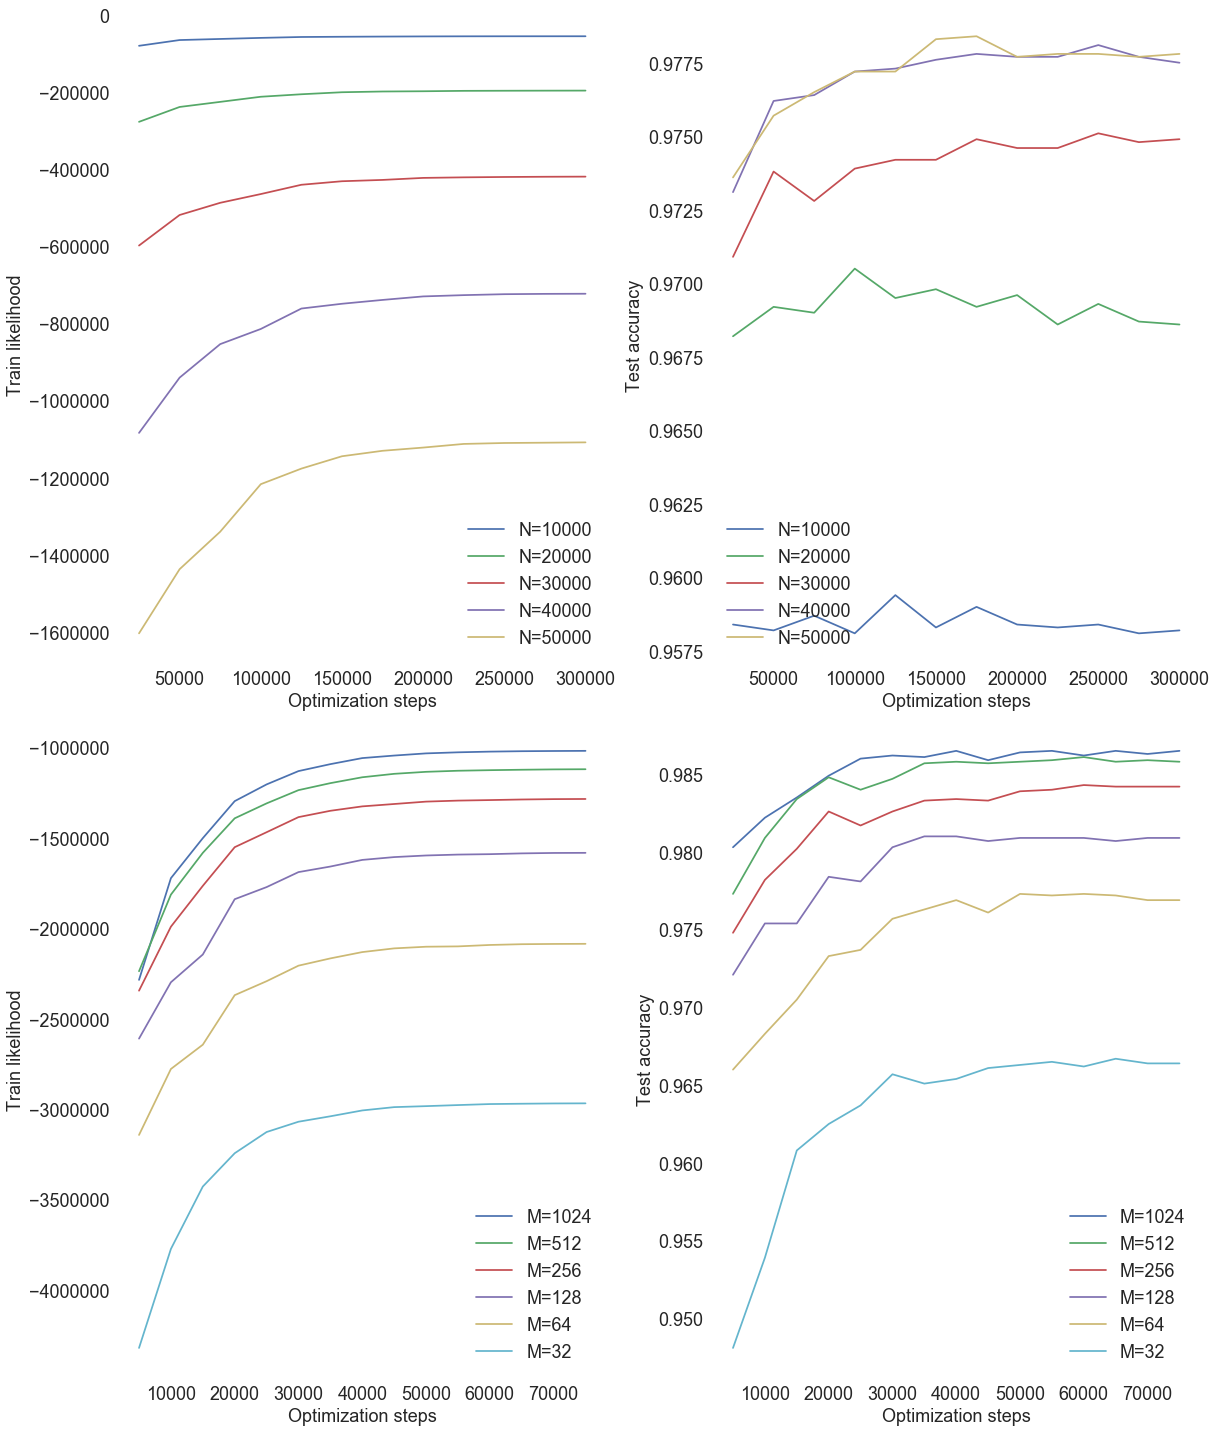

In [4]:
plot_shape = (2, 2)
figure = plt.figure(figsize=(17, 10 * plot_shape[1]))

def plot_likelihood_accuracy(experiments, label_fn, row=0):
    axis = plt.subplot2grid(plot_shape, (row, 0)) 

    for i, experiment in enumerate(experiments):
        likelihood = experiment['log']['train_log_likelihood'].values
        global_step = experiment['log']['global_step'].values
        label = label_fn(experiment)
        axis.plot(global_step, likelihood, c="C{}".format(i), label=label)
        axis.set_xlabel('Optimization steps')
        axis.set_ylabel('Train likelihood')
    axis.legend();


    axis = plt.subplot2grid(plot_shape, (row, 1))

    for i, experiment in enumerate(experiments):
        test_accuracy = experiment['log']['test_accuracy'].values
        global_step = experiment['log']['global_step'].values
        label = label_fn(experiment)
        axis.plot(global_step, test_accuracy, c="C{}".format(i), label=label)
        axis.set_xlabel('Optimization steps')
        axis.set_ylabel('Test accuracy')

    axis.legend();
    plt.tight_layout();
    
    
M100_experiments = [e for e in experiments if e['flags']['M'] == 100]
plot_likelihood_accuracy(M100_experiments, lambda e: "N={}".format(e['flags']['N']))


M_experiments = [e for e in experiments if e['flags']['N'] == 60000]
M_experiments.sort(key=lambda a: -a['flags']['M'])
plot_likelihood_accuracy(M_experiments, lambda e: "M={}".format(e['flags']['M']), row=1)

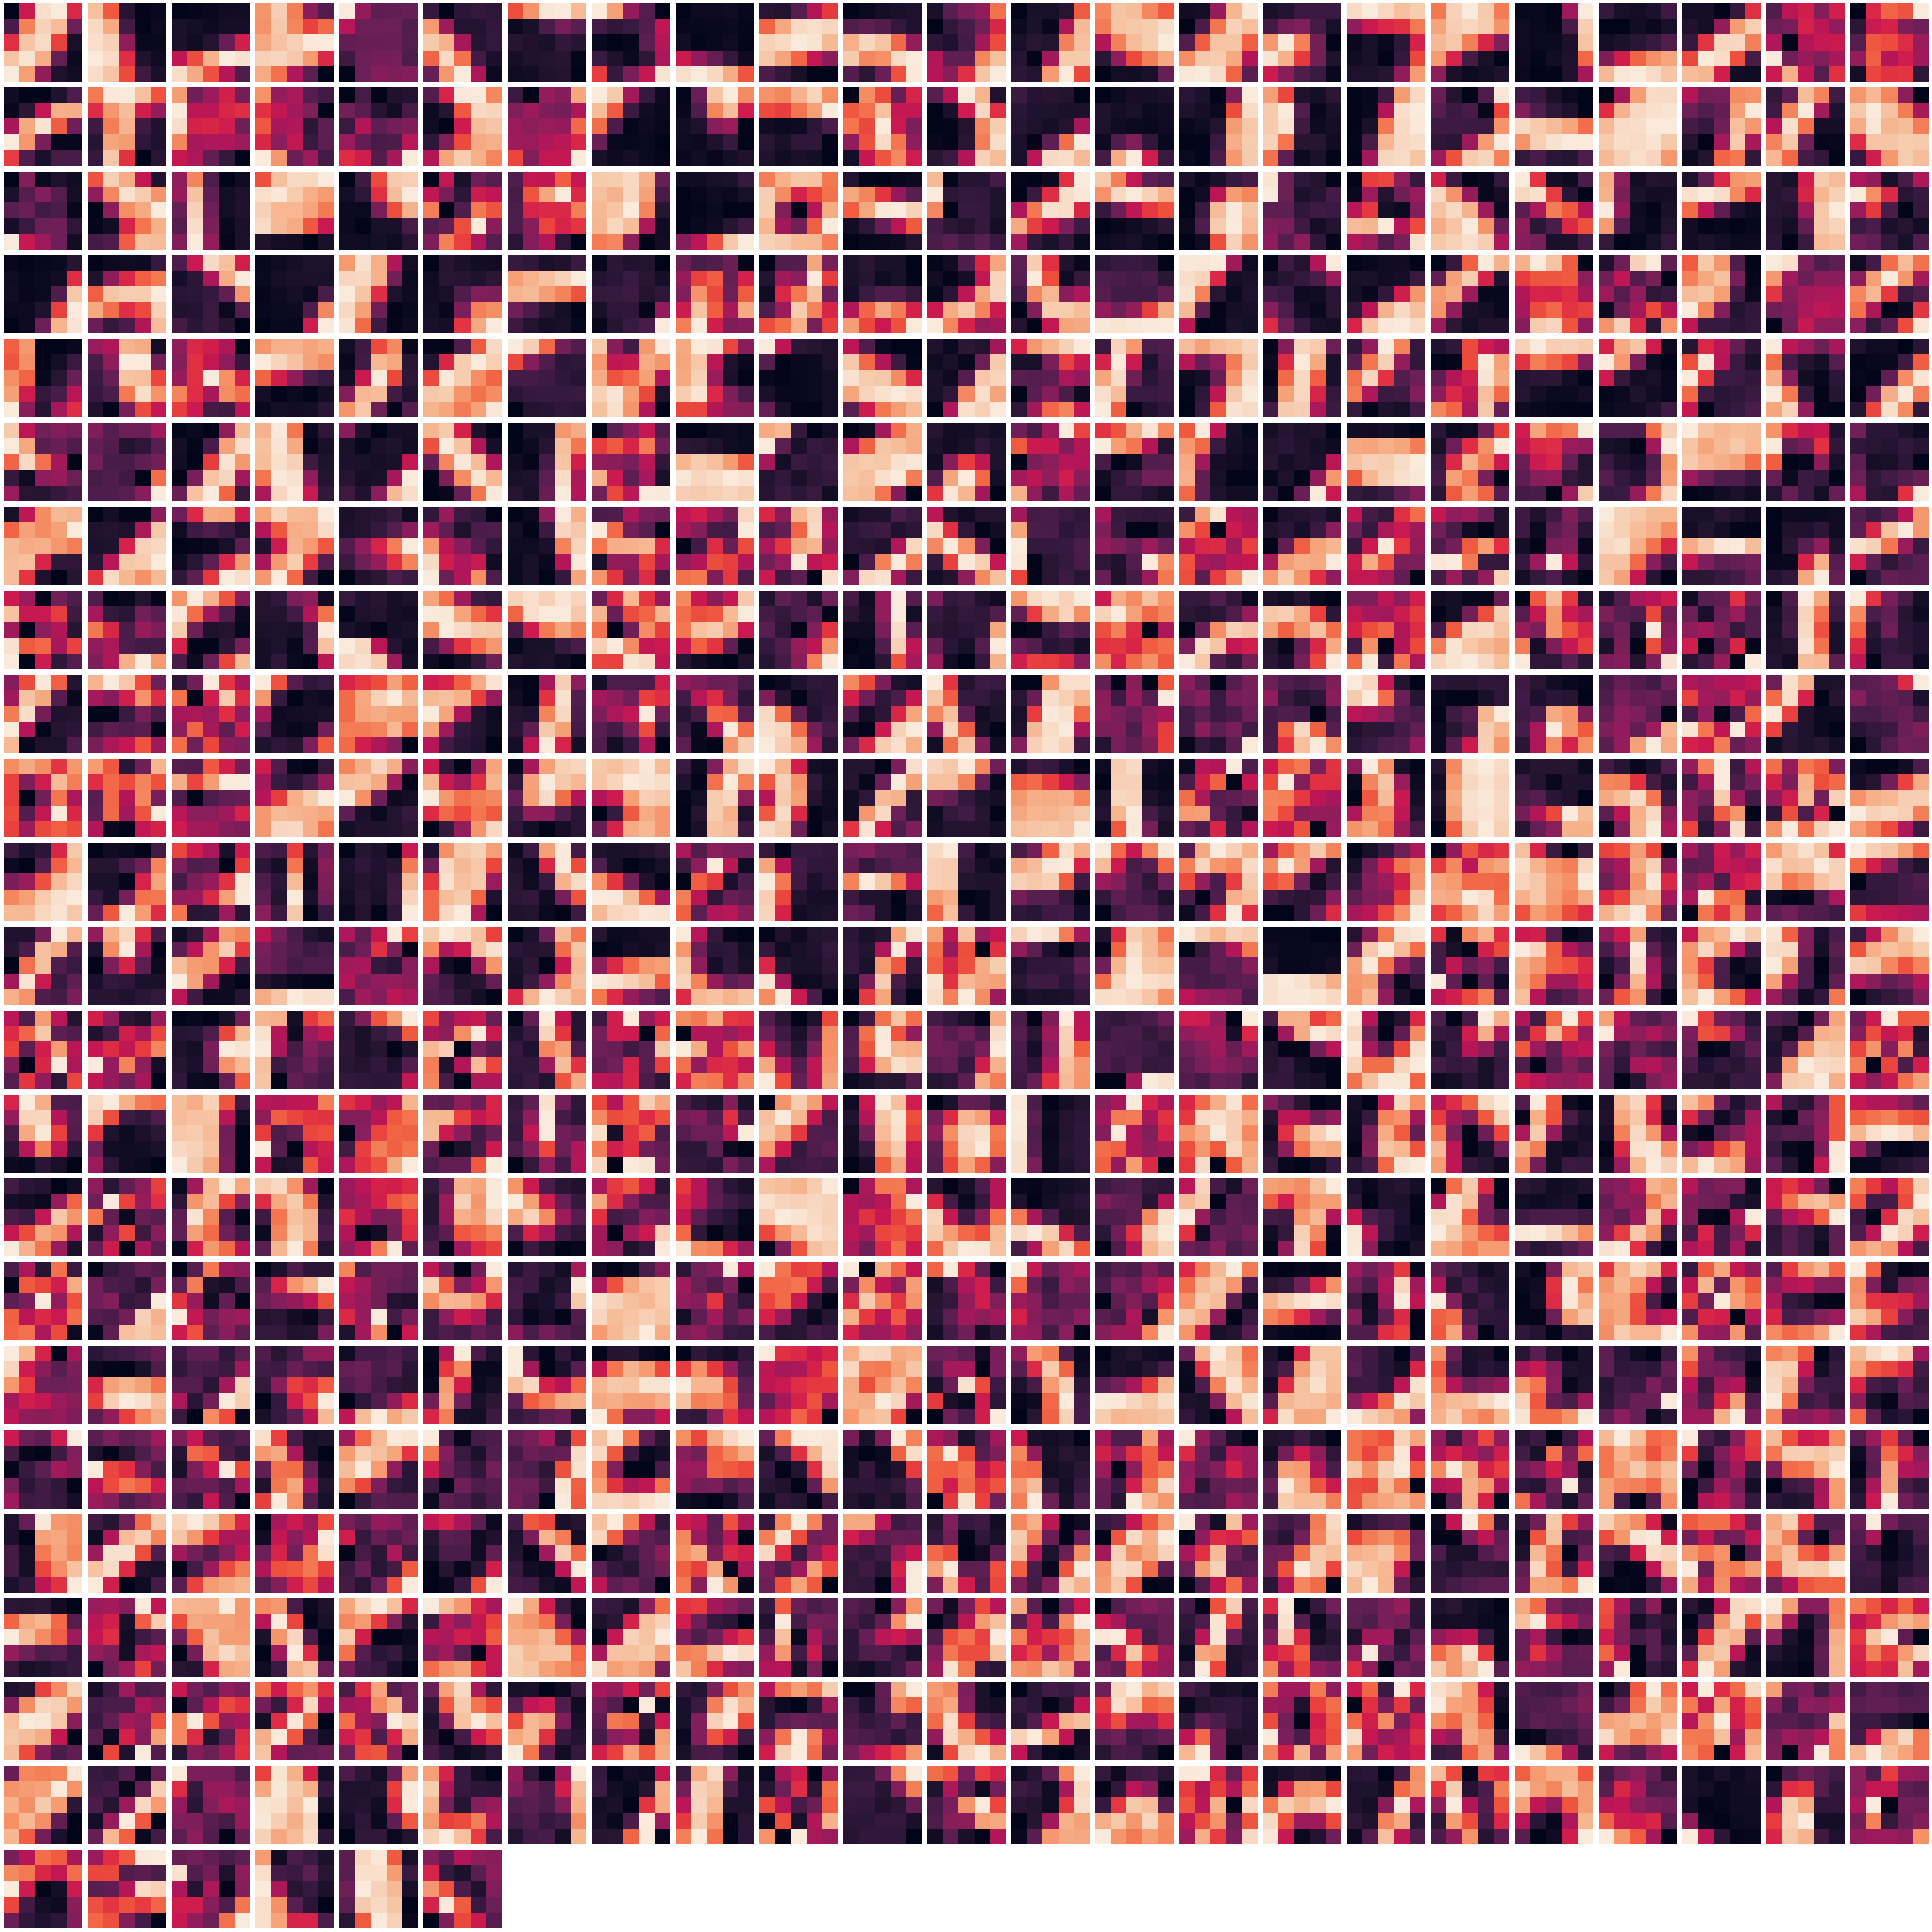

In [5]:
def tile_inducing_points(points):
    points = points.reshape(-1, 5, 5)
    rows = int(np.ceil(np.sqrt(points.shape[0])))
    columns = int(np.ceil(np.sqrt(points.shape[0])))
    height_padding = rows - 1
    width_padding = columns - 1
    point_shape = points.shape[1:]
    height = point_shape[0] * rows + height_padding
    width = point_shape[0] * columns + width_padding
    out = np.zeros((height, width), dtype=np.float32)
    for row_index in range(rows):
        for column_index in range(columns):
            point_index = row_index * rows + column_index
            if point_index >= points.shape[0]:
                break;
            current_point = points[point_index]
            axis = plt.subplot2grid((rows, columns), (row_index, column_index))
            axis.imshow(current_point)
            axis.yaxis.set_visible(False)
            axis.xaxis.set_visible(False)
    return out


inducing_points = np.load('../results/N60000_M512/inducing_points.npy')
figure = plt.figure(figsize=(50, 50))
tile_inducing_points(inducing_points)
plt.tight_layout()